### 데이터 불러오기

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kkyung0131","key":"e3e7fecbdbf98b2a60ba9f3dee5d5def"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 110MB/s]


In [7]:
!unzip nlp-getting-started.zip

Archive:  nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


### 1. Importing the necessary libraries

In [8]:
import numpy as np
import pandas as pd

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Reading the datasets

In [9]:
# train dataset
train = pd.read_csv("train.csv")
print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# test data
test = pd.read_csv("test.csv")
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### 3. Basic EDA

#### missing value

In [12]:
print(train.isnull().sum())
print(test.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


#### exploring the target column

In [21]:
target_counts = train['target'].value_counts()
print(target_counts)

disaster_tweets = train[train['target']==1]['text']
print(disaster_tweets.values[1])

nondisaster_tweets = train[train['target']==0]['text']
print(nondisaster_tweets.values[1])

target
0    4342
1    3271
Name: count, dtype: int64
Forest fire near La Ronge Sask. Canada
I love fruits


<Axes: xlabel='target', ylabel='count'>

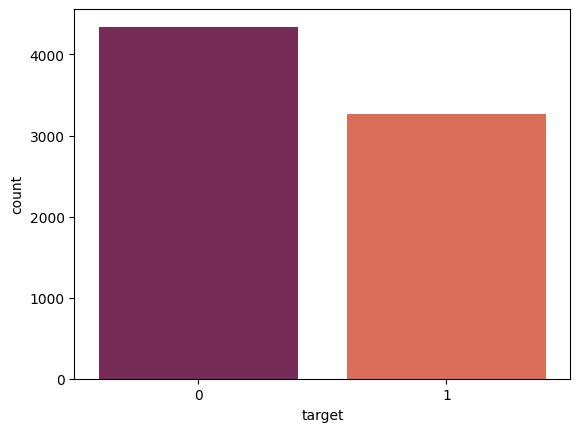

In [19]:
sns.barplot(x=target_counts.index, y=target_counts, palette='rocket')

#### exploring the 'keyword' column

<Axes: xlabel='count', ylabel='keyword'>

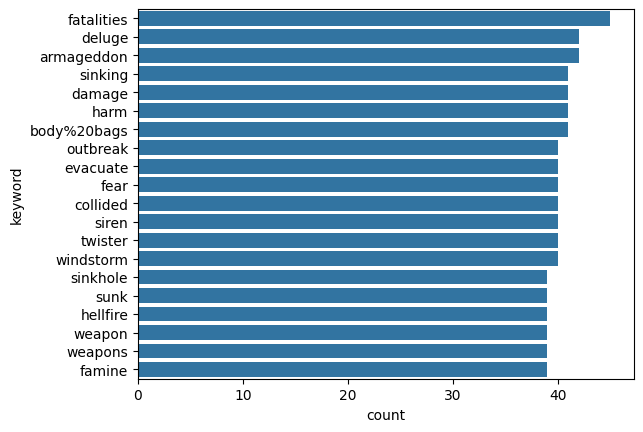

In [22]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20], orient='h')

In [23]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

target
1    102
0     40
Name: count, dtype: int64

#### exploring the 'location' column

<Axes: xlabel='count', ylabel='location'>

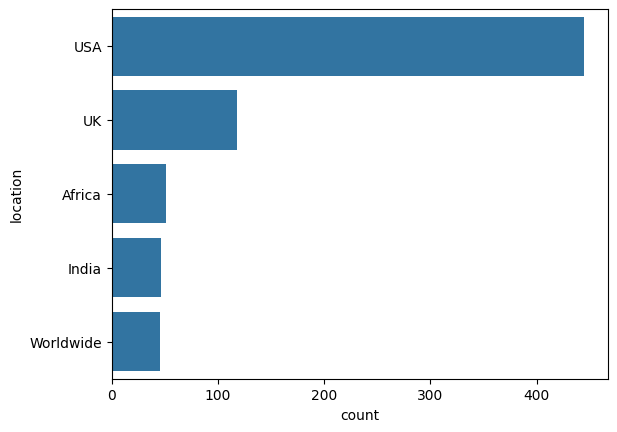

In [24]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

### 4. Text Data Preprocessing

data cleaning
- lower or uppercase
- removing noise
- tokenization
- stopword removal

more data cleaning after tokenization
  - stemming
  - lemmatization
  - POS tagging

#### data cleaning

In [25]:
def clean_text(text):
  text = text.lower()  # 모두 소문자로 변경
  text = re.sub('\[.*?\]', '', text)  # 대괄호 사이 모든 내용 제거
  text = re.sub('https?://\S+|www\.\S+', '', text)  # URL 제거
  text = re.sub('<.*?>+', '', text)  # < > 사이 모든 내용 제거
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # 문장부호 제거
  text = re.sub('\n', '', text)  # 줄바꿈 제거
  text = re.sub('\w*\d\w*', '', text)  # 숫자가 포함된 단어 제거
  return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

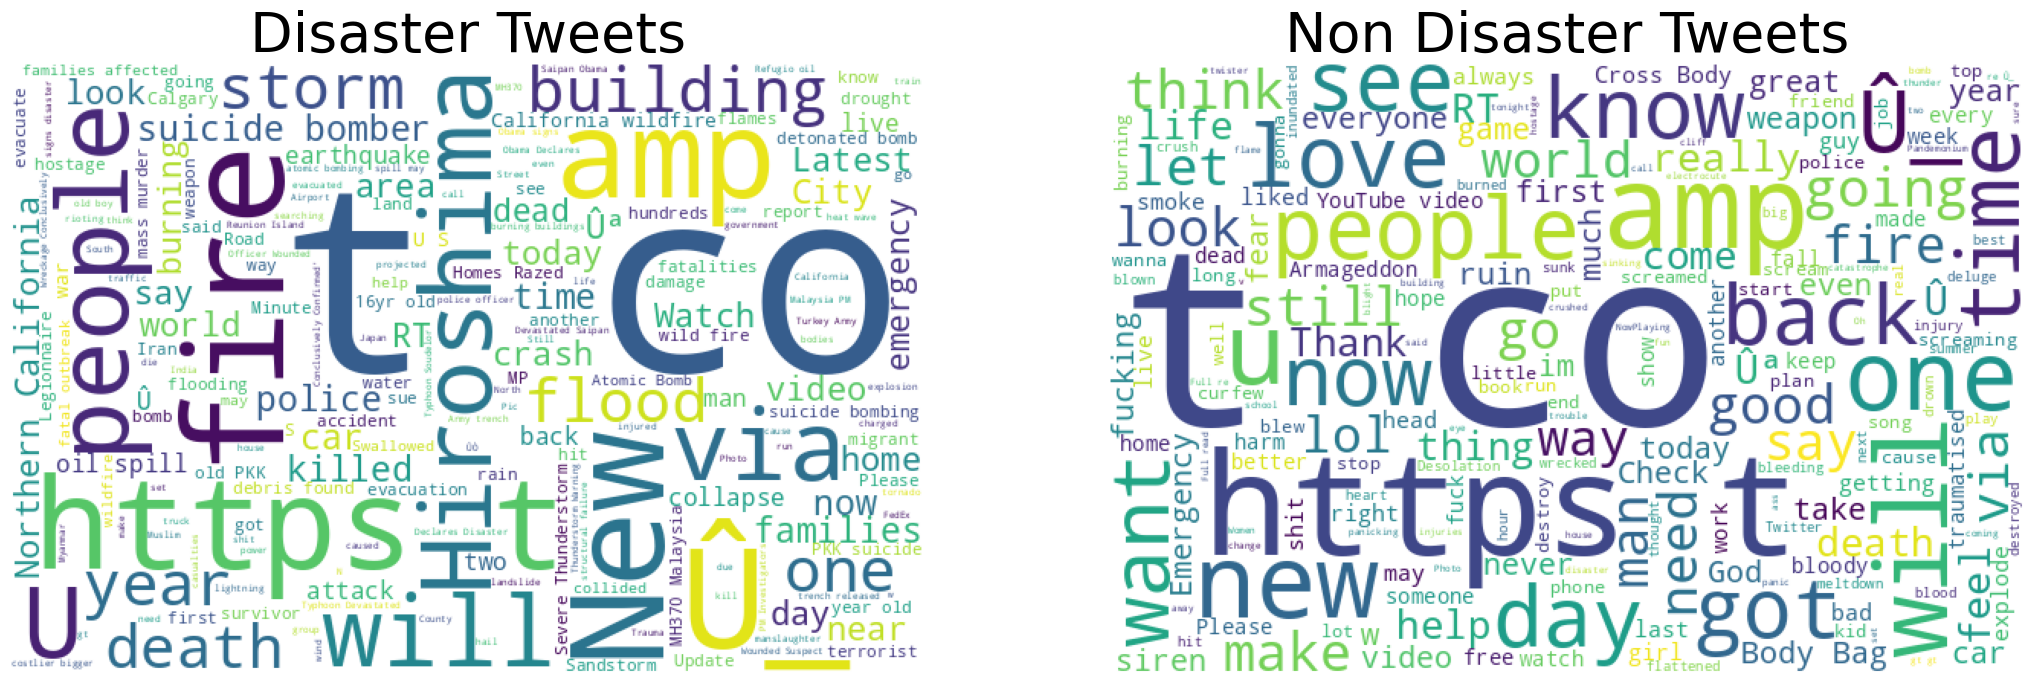

In [27]:
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(nondisaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

#### tokenization

In [31]:
text = "Are you coming , aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')

print("Example Text: ",text)
print("-----------------------------------------------------------------------------------")
print("Tokenization by whitespace:- ",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:- ",tokenizer2.tokenize(text))
print("Tokenization by punctuation:- ",tokenizer3.tokenize(text))
print("Tokenization by regular expression:- ",tokenizer4.tokenize(text))

Example Text:  Are you coming , aren't you
-----------------------------------------------------------------------------------
Tokenization by whitespace:-  ['Are', 'you', 'coming', ',', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer:-  ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation:-  ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression:-  ['Are', 'you', 'coming', 'aren', 't', 'you']


In [32]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

#### stopwords removal

In [34]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
def remove_stopwords(text):
  words = [w for w in text if w not in stopwords.words('english')]
  return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


#### token normalization

In [38]:
def combine_text(list_of_text):
  combined_text = ' '.join(list_of_text)
  return combined_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [39]:
# all
def text_preprocessing(text):
  tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
  nopunc = clean_text(text)
  tokenized_text = tokenizer.tokenize(nopunc)
  remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
  combined_text = ' '.join(remove_stopwords)
  return combined_text

### 5. Transforming tokens to a vector

#### Bag of Words

In [40]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


#### TFIDF

In [41]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

### 6. Building a text classification model

#### Logistic Regression Classifier

In [42]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors,
                                         train['target'], cv=5, scoring='f1')
scores

array([0.59865255, 0.49611063, 0.57166948, 0.56290774, 0.68789809])

In [43]:
clf.fit(train_vectors, train['target'])

LogisticRegression()

In [45]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf,
                                         train['target'], cv=5, scoring='f1')
scores

array([0.57229525, 0.49673203, 0.54277829, 0.46618106, 0.64768683])

In [50]:
clf_tfidf.fit(train_tfidf, train['target'])

LogisticRegression()

#### Naives Bayes Classifier

In [46]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors,
                                         train['target'], cv=5, scoring='f1')
scores

array([0.63149079, 0.60675773, 0.68575519, 0.64341085, 0.72505092])

In [47]:
clf_NB.fit(train_vectors, train['target'])

MultinomialNB()

In [48]:
clf_NB_tfidf = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_tfidf, train_tfidf,
                                         train['target'], cv=5, scoring='f1')
scores

array([0.57590597, 0.57092511, 0.61135371, 0.5962963 , 0.7393745 ])

In [49]:
clf_NB_tfidf.fit(train_tfidf, train['target'])

MultinomialNB()

#### XGBoost

In [51]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors,
                                         train["target"], cv=5, scoring="f1")
scores

array([0.49406688, 0.37087379, 0.43429637, 0.3780359 , 0.52307692])

In [52]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf,
                                         train["target"], cv=5, scoring="f1")
scores

array([0.47191011, 0.36113837, 0.42638623, 0.38949672, 0.52812202])

#### making the submission

In [54]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

submission_file_path = "sample_submission.csv"
test_vectors=test_tfidf
submission(submission_file_path,clf_NB_tfidf,test_vectors)

pd.read_csv("submission.csv").head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1
